In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
from PIL import Image
import cv2

Connect to the shared folder in Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

def load_csv_from_drive(file_path):

    file_path = '/content/drive/My Drive/DATASCI 281/' + file_path

    # Check if the file exists before attempting to load
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        print("CSV file loaded successfully!")
        print(df.head()) # Display the first few rows of the dataframe
    else:
        print(f"File not found at: {file_path}")
        print("Please ensure the folder and file names are correct and Google Drive is mounted.")
    return df

Mounted at /content/drive


In [4]:
# Load the metadata file
metadata_df = load_csv_from_drive('ISIC_2019_cleaned/resampled_metadata.csv')


CSV file loaded successfully!
                                image category augmentation_method
0  ISIC_0068778_preprocessed_rot0.jpg      MEL                rot0
1  ISIC_0058285_preprocessed_rot0.jpg      MEL                rot0
2  ISIC_0073194_preprocessed_rot0.jpg      MEL                rot0
3  ISIC_0058003_preprocessed_rot0.jpg      MEL                rot0
4  ISIC_0070105_preprocessed_rot0.jpg      MEL                rot0


In [5]:
# Add the dimensions to the metadata file (this process takes 30+ min)
folder_path = '/content/drive/My Drive/DATASCI 281/ISIC_2019_cleaned/'
for idx in tqdm(metadata_df.index,desc="Processing Files"):
    height, width = Image.open(folder_path + metadata_df.loc[idx, 'image']).size
    metadata_df.loc[idx, 'width'] = width
    metadata_df.loc[idx, 'height'] = height

metadata_df.to_csv('/content/drive/My Drive/DATASCI 281/resampled_metadata.csv', index=False)


Processing Files: 100%|██████████| 8000/8000 [32:24<00:00,  4.11it/s]


CSV file loaded successfully!
                                image category augmentation_method   width  \
0  ISIC_0068778_preprocessed_rot0.jpg      MEL                rot0  1024.0   
1  ISIC_0058285_preprocessed_rot0.jpg      MEL                rot0  1024.0   
2  ISIC_0073194_preprocessed_rot0.jpg      MEL                rot0  1024.0   
3  ISIC_0058003_preprocessed_rot0.jpg      MEL                rot0  1024.0   
4  ISIC_0070105_preprocessed_rot0.jpg      MEL                rot0  1024.0   

   height  
0  1024.0  
1  1024.0  
2  1024.0  
3  1024.0  
4  1024.0  


<Axes: >

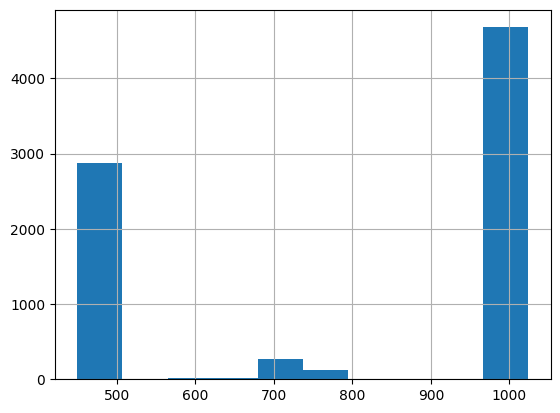

In [12]:
# Load the new metadata file
metadata_df = load_csv_from_drive('resampled_metadata.csv')

metadata_df['width'].hist()

In [13]:
# Check sizes for each group
metadata_df.groupby('category').agg({'width': ['min', 'max', 'mean']})

width                 
            min     max     mean
category                        
AK        450.0  1024.0  937.326
BCC       450.0  1024.0  922.402
BKL       450.0  1024.0  734.216
DF        450.0  1024.0  755.942
MEL       450.0  1024.0  831.618
NV        450.0  1024.0  673.361
SCC       450.0  1024.0  842.042
VASC      450.0  1024.0  702.560

In [8]:
metadata_df.head()

,image,category,augmentation_method,width,height
0,ISIC_0068778_preprocessed_rot0.jpg,MEL,rot0,1024.0,1024.0
1,ISIC_0058285_preprocessed_rot0.jpg,MEL,rot0,1024.0,1024.0
2,ISIC_0073194_preprocessed_rot0.jpg,MEL,rot0,1024.0,1024.0
3,ISIC_0058003_preprocessed_rot0.jpg,MEL,rot0,1024.0,1024.0
4,ISIC_0070105_preprocessed_rot0.jpg,MEL,rot0,1024.0,1024.0


In [11]:
# show a pair of random images for each category, one with width 450 and one with width of 1024.

def show_random_images_by_category(df, folder_path, random_state):
  """
  Displays a pair of random images for each category, one with width 450
  and one with width of 1024, arranged in a matrix with images of the same
  category side by side.

  Args:
    df: DataFrame containing image metadata including 'category', 'width', and 'image'.
    folder_path: The path to the folder containing the images.
  """
  categories = df['category'].unique()
  num_categories = len(categories)
  num_cols = 2  # Two columns for each category (width 450 and width 1024)

  fig, axes = plt.subplots(num_categories, num_cols, figsize=(15, 5 * num_categories))

  for i, category in enumerate(categories):
    category_df = df[df['category'] == category]

    # Get random image with width 450
    img_450_df = category_df[category_df['width'] == 450].sample(1, random_state=random_state)
    img_450_path = os.path.join(folder_path, img_450_df.iloc[0]['image'])
    img_450 = Image.open(img_450_path)

    # Get random image with width 1024
    img_1024_df = category_df[category_df['width'] == 1024].sample(1, random_state=random_state)
    img_1024_path = os.path.join(folder_path, img_1024_df.iloc[0]['image'])
    img_1024 = Image.open(img_1024_path)

    # Plot the images
    axes[i, 0].imshow(img_450)
    axes[i, 0].set_title(f'{category} (Width: 450)')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(img_1024)
    axes[i, 1].set_title(f'{category} (Width: 1024)')
    axes[i, 1].axis('off')

  plt.tight_layout()
  plt.show()

show_random_images_by_category(metadata_df, folder_path, 100)


Output hidden; open in https://colab.research.google.com to view.

In [15]:
def resize_images(metadata_df, folder_source, folder_target, target_size):
    df = metadata_df[metadata_df['width'] > target_size[0]]
    for idx in tqdm(df.index,desc="Processing Files"):
        img_path = folder_source + df.loc[idx, 'image']
        img = np.array(Image.open(img_path))
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA) # the inter_area method includes the gaussian effect
        resized_img = Image.fromarray(resized_img)
        resized_img.save(folder_target + df.loc[idx, 'image'])
    metadata_df[['width', 'height']] = target_size
    return metadata_df

folder_source = '/content/drive/My Drive/DATASCI 281/ISIC_2019_cleaned/'
folder_target = '/content/drive/My Drive/DATASCI 281/ISIC_2019_cleaned_resized/'
resize_images(metadata_df, folder_source, folder_target, (450, 450))

Processing Files: 100%|██████████| 5125/5125 [02:52<00:00, 29.65it/s]


,image,category,augmentation_method,width,height
0,ISIC_0068778_preprocessed_rot0.jpg,MEL,rot0,450,450
1,ISIC_0058285_preprocessed_rot0.jpg,MEL,rot0,450,450
2,ISIC_0073194_preprocessed_rot0.jpg,MEL,rot0,450,450
3,ISIC_0058003_preprocessed_rot0.jpg,MEL,rot0,450,450
4,ISIC_0070105_preprocessed_rot0.jpg,MEL,rot0,450,450
...,...,...,...,...,...
7995,ISIC_0026645_preprocessed_rot90.jpg,SCC,rot90,450,450
7996,ISIC_0029417_preprocessed_rot90.jpg,SCC,rot90,450,450
7997,ISIC_0071393_preprocessed_rot90.jpg,SCC,rot90,450,450
7998,ISIC_0068266_preprocessed_rot90.jpg,SCC,rot90,450,450
